In [1]:
import pandas as pd
from preprocess import getPopularityIndex
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from preprocess import cleanData, getPopularityIndex, encodePandas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from preprocess import extractTweetFeatures , mostFrequentWords, getPopularityIndex, encodePandas, dropZeros, encodeSklearn, computePopularityIndex, computePopularityIndex_by_flw


In [2]:
X = pd.read_pickle('TwitterData_1e5_w0.pkl')

In [13]:
for i in range(len(X)):
    X['popularity'][i] -= X['favorite_count'][i]

/tmp/ipykernel_35565/2146874189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['popularity'][i] -= X['favorite_count'][i]


In [3]:
# X.drop(['mentions_tot_followers', 'mentions_tot_friends', 'mentions_tot_statuses'], axis=1, inplace=True)

y = computePopularityIndex(X, 5)
X = cleanData(X)
print('X dataframe has {} rows...'.format(len(X)))
numerical_columns = X._get_numeric_data().columns
categorical_columns = list(set(X.columns) - set(numerical_columns))
print('...with numerical columns:')
print(numerical_columns)
print('and categorical columns:')
print(categorical_columns)

print('\n')

X dataframe has 31067 rows...
...with numerical columns:
Index(['followers_count', 'friends_count', 'listed_count', 'statuses_count',
       'mentions_tot_followers', 'mentions_tot_friends',
       'mentions_tot_statuses', 'n_sentences', 'n_words', 'n_adjectives',
       'n_adverbs', 'n_nouns', 'n_pronouns', 'n_verbs', 'n_long_words',
       'n_hashtags', 'n_user_mentions'],
      dtype='object')
and categorical columns:
['time', 'is_reply', 'day', 'has_gif', 'has_urls', 'has_video', 'has_photo', 'has_symbols', 'has_questions']




In [4]:
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore', drop='first')
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)
    ])

In [5]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

feature_selection = SelectFromModel(RandomForestClassifier(), threshold = 0.01)

In [6]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.33, random_state=42)

(array([ 6097.,  2148.,  6979., 10830.,  5013.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

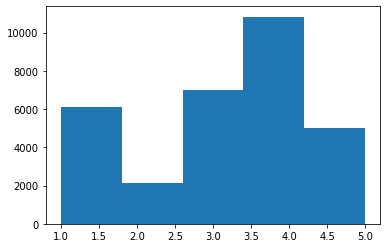

In [7]:
plt.hist(y, bins=5)

In [22]:
cv_inner= KFold(n_splits=2, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

classifier = SVC()

search = RandomizedSearchCV(estimator = classifier, param_distributions = hyppar_space, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

model = make_pipeline(preprocessor, search)

In [ ]:
model.fit(X,y)

In [24]:
model[1].best_params_

{'tol': 0.5, 'kernel': 'poly', 'degree': 3, 'C': 1}

In [18]:
svc = SVC(kernel='poly', degree=3, tol=0.05, C=50)
svc = make_pipeline(preprocessor, svc)
svc.fit(X1,y1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['time', 'is_reply', 'day',
                                                   'has_gif', 'has_urls',
                                                   'has_video', 'has_photo',
                                                   'has_symbols',
                                                   'has_questions']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  Index(['followers_count', 'friends_count', 'listed_count', 'statuses_count',
       'mentions_tot_followers', 'mentions_tot_friends',
       'mentions_tot_statuses', 'n_sent

In [19]:
svc.score(X2,y2)

0.5688091290354043

In [16]:
hyppar_space = dict()
hyppar_space['svc__C'] = [0.1, 1, 10, 50] #, 20, 30, 40, 50] #[1, 5, 10, 50, 100, 500, 1000]
# hyppar_space['svc__gamma'] = [0.1, 0.01, 0.001] #['auto', 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
hyppar_space['svc__degree'] = [2, 3, 4] #[1, 2, 3, 4]
hyppar_space['svc__tol'] = [0.04,0.06,0.1,0.5] #, 0.06, 0.1, 0.14]
hyppar_space['svc__kernel'] = ['poly'] #['rbf', 'poly', 'linear', 'sigmoid']

In [17]:
def nestedCV(X, y, classifier, space, preprocessor, k_inner=3, k_outer=10, n_jobs_gridsearch=1, scoring='accuracy'):

    cv_inner= KFold(n_splits=k_inner, shuffle=True, random_state=1)
    cv_outer = KFold(n_splits=k_outer, shuffle=True, random_state=1)

    feature_selection = SelectFromModel(RandomForestClassifier(), threshold = 0.01)
    model_inner = make_pipeline(feature_selection, classifier)

    search = GridSearchCV(model_inner, space, scoring=scoring, n_jobs=n_jobs_gridsearch, cv=cv_inner, refit=True)
    model = make_pipeline(preprocessor, search)

    scores = cross_validate(model, X, y, scoring=scoring, cv=cv_outer, n_jobs=-1, return_estimator=True, error_score='raise')

    return scores

In [18]:
scores = nestedCV(X, y, SVC(), hyppar_space, preprocessor, k_inner=3, k_outer=10)
a_file = open('nestedcv_best_svc_crrcted', 'wb')
import pickle
pickle.dump(scores, a_file)
a_file.close()

In [19]:
for estim in scores['estimator']:
    print(estim[1].best_params_)

{'svc__C': 50, 'svc__degree': 2, 'svc__kernel': 'poly', 'svc__tol': 0.06}
{'svc__C': 50, 'svc__degree': 3, 'svc__kernel': 'poly', 'svc__tol': 0.04}
{'svc__C': 50, 'svc__degree': 2, 'svc__kernel': 'poly', 'svc__tol': 0.04}
{'svc__C': 50, 'svc__degree': 3, 'svc__kernel': 'poly', 'svc__tol': 0.3}
{'svc__C': 50, 'svc__degree': 3, 'svc__kernel': 'poly', 'svc__tol': 0.04}
{'svc__C': 50, 'svc__degree': 2, 'svc__kernel': 'poly', 'svc__tol': 0.1}
{'svc__C': 50, 'svc__degree': 3, 'svc__kernel': 'poly', 'svc__tol': 0.06}
{'svc__C': 50, 'svc__degree': 3, 'svc__kernel': 'poly', 'svc__tol': 0.06}
{'svc__C': 50, 'svc__degree': 2, 'svc__kernel': 'poly', 'svc__tol': 0.5}
{'svc__C': 50, 'svc__degree': 2, 'svc__kernel': 'poly', 'svc__tol': 0.5}


In [20]:
scores['test_score']

array([0.46611668, 0.46493813, 0.46199175, 0.48025928, 0.48791986,
       0.4702416 , 0.45550972, 0.46258103, 0.47759434, 0.46875   ])

In [24]:
metrics = pd.read_pickle('nestedcv_best_svc_crrcted')

In [25]:
print(mean(metrics['test_score']), std(metrics['test_score']))

0.4695902383229006 0.009240314634799626
